## Useful Functions

In [128]:
def get_model( temp ):
    '''
    Function opens Phoenix file of specified temperature in 100 Kelvin increments from 2300 to 12000 Kelvin.
    Parameters
    ----------
    temp: str
        Desired temperature in 100K increments from 2300 to 12,000 Kelvin
        
    Returns
    -------
    wavelength: array
        Associated wavelengths for flux measurements from Phoenix FITS file, in Angstroms
        
    flux: array
        Flux measurements from Phoenix FITS file, in erg/s/cm^2
        
    temp: str
        See Parameters
    '''
    model_file = 'Extinction Vector Project/Med_Res_10K_Grid/lte0' + temp + '-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
    #what are the numbers here? -4.50-0.0
    hdulist = fits.open(model_file)
    flux = hdulist[0].data
    wavelength = np.exp(hdulist[0].header[('CRVAL1')]+hdulist[0].header[('CDELT1')]*np.arange(0,212027))/(10**4)
    return wavelength,flux

In [129]:
def getFMext(x,R):
    
    """ Fitzpatrick 1999, spectroscopic

        Inputs:  x = inverse wavelength in microns
                 R = ratio of A_V to E(B-V)
                
        Outputs:  returns Al/AV in magnitude units
    """
    
    from scipy.interpolate import interp1d
    
    import numpy as np

    f99_anchor = 1.0E4 / np.array([np.inf, 26500., 12200., 6000., 5470., 4670., 4110., 2700., 2600.]) #microns
    #np.array creates an array
    #np.inf sets value to infinity
    #"anchor" wavelengths for the function to come--what is the pattern here?
    #x axis values
    
    a6000=-0.426+1.0044*R
    a5470=-0.050+1.0016*R
    a4670= 0.701+1.0016*R
    a4110= 1.208+1.0032*R-0.00033*R**2
    #for values in array, apply R in some way
    #create new values using R. Where do coefficients of R come from?

    af99_anchor = np.array([0.0, 0.265, 0.829, a6000, a5470, a4670, a4110, 6.265, 6.591])/3.1
    #same shape as previous array so function can be created
    #create a new array, replacing numbers from original array with their corresponding constant
    #divide by 3.1: comparing to the "standard" R value of 3.1?
    #y axis values--tell extinction pattern of "anchor values"?
    
    f=interp1d(f99_anchor,af99_anchor, kind='cubic') 
    #create a 2-variable function between the two arrays, wavelength and magnitude of extinction
    #find a function of frequency (1/wavelength)
    
    return f(x)
    #A_lambda/A_V:a different value for each input wavelength (continuous function)

In [140]:
def PlotExtinguishedSpectrum(temp,extinction,R,scale):
    
    model_wavelengths = get_model(temp)[0]
    model_spectrum = scale*(get_model(temp)[1])/10000/10000
    Al_over_Av = getFMext(1.0/model_wavelengths, R)
    
    extinguished_spectrum = model_spectrum*10.0**(-0.4*Al_over_Av*extinction)
    
    plt.plot(model_wavelengths,extinguished_spectrum)

In [131]:
def PlotSpectrumData(filename,columns):
    modelfile = filename
    wavelength, flux = np.loadtxt(filename, usecols=columns, skiprows=0, unpack=True)
    plt.plot(wavelength,flux)
    

In [132]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from scipy.interpolate import interp1d

from astropy.io import fits

%matplotlib inline

(0.9, 2.5)

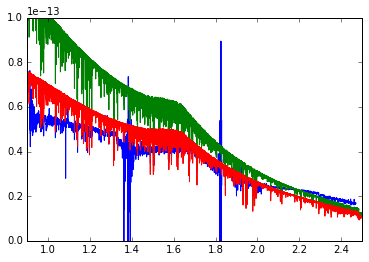

In [159]:
PlotSpectrumData('Extinction Vector Project/testingspectra/AATau.Tspec2008.txt',(0,1))
PlotExtinguishedSpectrum('4000',0,2.0,10**-19)
PlotExtinguishedSpectrum('4000',1.3,2.0,10**-19)

axes = plt.gca()
axes.set_ylim([0,10**-13])
axes.set_xlim([0.9,2.5])